In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 64
EPOCHS_BASE = 50
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
folder ="../FG-Net_Age/"
columns = ["GT","file name","a1","a2","a3","a4","a5","a6","a7","a8","a9","a10"]

### Load Data and preprocess

In [4]:
## mas anotaciones ne este dataset: http://yekara.com/age_annotations/

In [5]:
df_ann = pd.read_csv(folder+"fgnet_age_estimations.csv",header=None,names=columns)
gt_aux = df_ann["GT"].values

file_names = []
for value in df_ann["file name"].values:
    aux = value[7:-4].replace("_", '')
    if "M" in aux:
        split_v = "M"
    elif "F" in aux:
        split_v = "F"
    subject, age = aux.split(split_v)
    file_names.append( subject.zfill(3)+ "A"+ age.zfill(2)+".JPG" )
file_names

['022A18.JPG',
 '065A09.JPG',
 '034A25.JPG',
 '066A11.JPG',
 '034A30.JPG',
 '054A13.JPG',
 '031A16.JPG',
 '081A00.JPG',
 '039A19.JPG',
 '039A07.JPG',
 '062A35.JPG',
 '038A10.JPG',
 '008A13.JPG',
 '049A04.JPG',
 '025A19.JPG',
 '007A37.JPG',
 '066A00.JPG',
 '017A22.JPG',
 '015A14.JPG',
 '076A11.JPG',
 '034A44.JPG',
 '045A06.JPG',
 '077A14.JPG',
 '043A03.JPG',
 '014A40.JPG',
 '047A23.JPG',
 '002A26.JPG',
 '028A41.JPG',
 '066A04.JPG',
 '040A21.JPG',
 '015A00.JPG',
 '082A20.JPG',
 '024A07.JPG',
 '043A23.JPG',
 '005A30.JPG',
 '039A15.JPG',
 '002A04.JPG',
 '013A23.JPG',
 '061A18.JPG',
 '078A13.JPG',
 '056A12.JPG',
 '022A26.JPG',
 '027A02.JPG',
 '015A10.JPG',
 '078A11.JPG',
 '042A00.JPG',
 '041A04.JPG',
 '072A29.JPG',
 '004A37.JPG',
 '006A28.JPG',
 '065A02b.JPG',
 '074A01.JPG',
 '071A44.JPG',
 '078A02.JPG',
 '076A12.JPG',
 '015A12.JPG',
 '008A35.JPG',
 '032A10.JPG',
 '009A16a.JPG',
 '052A18.JPG',
 '002A36.JPG',
 '006A55.JPG',
 '046A20.JPG',
 '049A08.JPG',
 '075A06.JPG',
 '054A11.JPG',
 '003A47

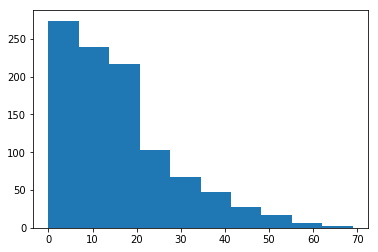

Minimum data on split:  250.5
Splits obtained:  4
Splits obtained ammount:  [274, 271, 266, 0]


array([ 0.,  7., 15., 26., inf])

In [6]:
## discretizar..
plt.hist(gt_aux)
plt.show()

##stratified range..
limits = [0]
pos_values = np.unique(gt_aux)

N = gt_aux.shape[0]
splits = 4 #5 ,7,8
acum_split = []
data_by_split = N/(splits) #minimum data on split
print("Minimum data on split: ",data_by_split)

for i in range(splits-1):
    if i != len(limits)-1:
        break
    upper_values = pos_values[pos_values>=limits[i]]
    for value in upper_values: #find the upper limit
        range_v = (limits[i] <= gt_aux ) & (gt_aux < value)
        if np.sum(range_v) >= data_by_split:
            limits.append(value)
            acum_split.append(np.sum(range_v))
            break
range_v = (limits[-1] <= gt_aux ) & (gt_aux <=1)
up_lim = np.inf #max(np.max(pos_values), df_ann.iloc[:,2:].values.max())+0.01
limits.append(up_lim)
acum_split.append(np.sum(range_v))
limits = np.asarray(limits)

print("Splits obtained: ",len(acum_split))
print("Splits obtained ammount: ",acum_split)
limits

In [7]:
limits = [0, 9, 16, 25, 35, 45, np.inf ] # << mas dificil que balanceado
"""
    Children (1-14) CLASS 0
    Youth (14-25) CLASS 1
    ADULTS (25-40) CLASS 2
    Middle age (40-60) CLASS 3
    Very Old (>60) CLASS 4
"""

limits = [0, 2.5, 7.5, 12.5, 19.5, 36.5, 50.5, np.inf ]
"""
Label		Age Range
1		0-2
5		3-7
10		8-12
16		13-19
28		20-36
51		37-65
75		66+
"""

#limits =  list(np.arange(0, np.max(gt_aux), np.max(gt_aux)/7 )) #[0, 2.5, 7.5, 12.5, 19.5, 36.5, 50.5, np.inf ]
#limits[-1] = np.inf
#limits

'\nLabel\t\tAge Range\n1\t\t0-2\n5\t\t3-7\n10\t\t8-12\n16\t\t13-19\n28\t\t20-36\n51\t\t37-65\n75\t\t66+\n'

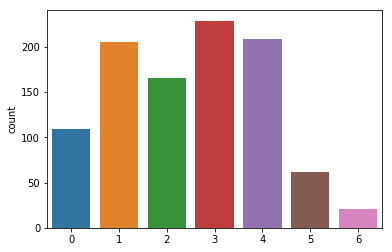

In [8]:
def continous_2_cat(data):
    if data == -1:
        return -1
    return np.where(limits <= data )[0][-1]

Z_data = np.zeros((df_ann.shape[0]), dtype='int')
for i in range(Z_data.shape[0]):
    Z_data[i] = continous_2_cat(gt_aux[i]) #int(gt_aux[i]/10)
K = Z_data.max()+1

sns.countplot(Z_data)
plt.show()

### buscando test

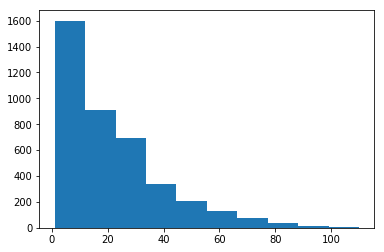

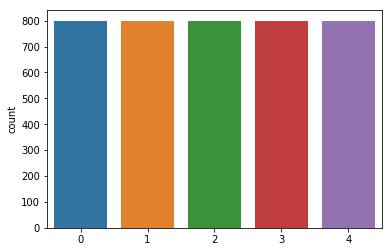

{0: 800, 1: 800, 2: 800, 3: 800, 4: 800}

In [10]:
folder_img_te = "/home/fmena/Downloads/UTKFace/"
file_images_te = os.listdir(folder_img_te)

gt_aux_c = []
Z_data_te = []
file_names_te = []
count_v = {k:0 for k in range(K)}
for value in file_images_te:
    #age, gender, race, id_jpg = value.split("_")
    age = float(value.split("_")[0])
    age_cat = continous_2_cat(age)
    
    if count_v[age_cat] < 800: #semi-balanceado..
        gt_aux_c.append(age)
        Z_data_te.append(age_cat)
        file_names_te.append(value)
        
        count_v[Z_data_te[-1]] +=1
Z_data_te = np.asarray(Z_data_te)

## discretizar..
plt.hist(gt_aux_c)
plt.show()
sns.countplot(Z_data_te)
plt.show()

count_v

In [9]:
from PIL import Image
folder_img = folder+"FGNET/images/"
X_images = []
for i,values in enumerate(file_names):
    I = Image.open(folder_img+values).convert("RGB") 
    I = I.resize((224,224), Image.ANTIALIAS) #reshape it
    #print(I.size)
    X_images.append(np.asarray(I).astype("uint8"))
    I.close()
gc.collect()
X_images = np.asarray(X_images)
print("Images shapes: ",X_images.shape)

Images shapes:  (1002, 224, 224, 3)


In [10]:
def dat_aug(file_names, folder_img, ang=90):
    return_v = []
    for i,values in enumerate(file_names):
        I = Image.open(folder_img+values).convert("RGB") 
        I = I.resize((224,224), Image.ANTIALIAS) #reshape it
        I = I.rotate(np.random.uniform(-ang,ang))
        return_v.append(np.asarray(I).astype("uint8"))
        I.close()
    return np.asarray(return_v)

### data augment-- rotate?

X_images_aug1 = dat_aug(file_names, folder_img, ang=10)
X_images_aug2 = dat_aug(file_names, folder_img, ang=40)
X_images_aug3 = dat_aug(file_names, folder_img, ang=90)

print("Images shapes: ",X_images_aug1.shape)

Images shapes:  (1002, 224, 224, 3)


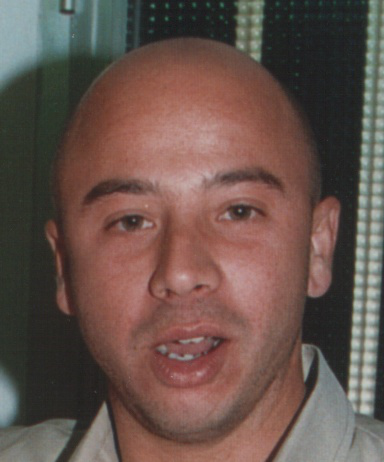

In [10]:
from PIL import Image
Image.open(folder+"FGNET/images/035A23a.JPG")

In [6]:
pool_mo = "avg"

#now pass through VGG
from code.learning_models import through_VGG, through_InceptionV3
new_X = through_VGG(X_images.astype('float32'), pooling_mode=pool_mo)
#new_X = through_InceptionV3(X_images.astype('float32'), pooling_mode=pool_mo)
print("New shape through VGG: ",new_X.shape)
new_X

New shape through VGG:  (1002, 512)


array([[0.        , 0.        , 0.        , ..., 0.30005205, 0.01534462,
        0.66252375],
       [0.        , 0.        , 0.3823775 , ..., 4.5461593 , 2.617739  ,
        0.02364997],
       [0.        , 0.        , 0.        , ..., 1.6080321 , 1.9697523 ,
        0.18695028],
       ...,
       [0.        , 0.46689925, 0.        , ..., 1.0656335 , 0.03819171,
        0.14722537],
       [0.        , 0.22692089, 0.58484757, ..., 2.0427058 , 0.28857392,
        0.32262632],
       [0.        , 0.        , 0.706046  , ..., 5.170857  , 0.44488853,
        0.7249939 ]], dtype=float32)

In [11]:
pool_mo = None #"avg"

from code.learning_models import through_CNNFace
#"senet50" # 'vgg16', "resnet50", "senet50"
new_X = through_CNNFace(X_images.astype('float32'), weights_path="vgg16",pooling_mode=pool_mo)

print("New shape through VGG: ",new_X.shape)
new_X

New shape through VGG:  (1002, 7, 7, 512)


array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        

In [12]:
new_X1 = through_CNNFace(X_images_aug1.astype('float32'), weights_path="vgg16",pooling_mode=pool_mo)
new_X2 = through_CNNFace(X_images_aug2.astype('float32'), weights_path="vgg16",pooling_mode=pool_mo)
new_X3 = through_CNNFace(X_images_aug3.astype('float32'), weights_path="vgg16",pooling_mode=pool_mo)
print("New shape through VGG: ",new_X1.shape)

New shape through VGG:  (1002, 7, 7, 512)


In [19]:
pool_mo = None #"avg"

from code.learning_models import through_CNNFace
#"senet50" # 'vgg16', "resnet50", "senet50"
new_X_te = through_CNNFace(X_images_te.astype('float32'), weights_path="vgg16",pooling_mode=pool_mo)

print("New shape through VGG: ",new_X_te.shape)
new_X_te

NameError: name 'X_images_te' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
new_X = std.fit_transform(new_X)
#new_X_te = std.transform(new_X_te)
new_X

In [4]:
X = #np.load(folder+"GalaxyZoo_data.npy")
X.shape

(61578, 80, 80, 3)

### Load annotations / Generate

In [13]:
df_ann = pd.read_csv(folder+"fgnet_age_estimations.csv",header=None,names=columns)

r_obs_aux = np.zeros((df_ann.shape[0],K))
for i,anns in enumerate(df_ann.iloc[:,2:].values):
    for value in anns:
        r_obs_aux[i, continous_2_cat(value) ] +=1
r_obs_aux

array([[0., 0., 0., ..., 7., 1., 0.],
       [0., 2., 8., ..., 0., 0., 0.],
       [0., 0., 0., ..., 8., 1., 0.],
       ...,
       [0., 0., 0., ..., 5., 0., 0.],
       [0., 0., 0., ..., 6., 3., 0.],
       [0., 0., 0., ..., 8., 0., 0.]])

In [100]:
df_ann2 = pd.read_csv(folder+"/kara2015_ageannotations/age_annotations.csv", sep=';')

r_obs2 = np.zeros((df_ann.shape[0],K))
for aux in df_ann2.values:# i,anns in enumerate(df_ann2.iloc[:,2:].values):
    id_ann = aux[0]#identidades :o
    
    f_name = aux[1]
    if f_name == "041A013.JPG":
        f_name = "041A13.JPG"
    id_data = file_names.index(f_name)
    ann = [aux[2]]
    
    r_obs2[ id_data, continous_2_cat(ann) ] +=1
    
r_obs2

array([[10.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [10.,  0.,  0., ...,  0.,  0.,  0.]])

In [103]:
r_obs2.sum(axis=-1)

array([10., 10., 10., ..., 10., 10., 10.])

In [27]:
#http://chenlab.ece.cornell.edu/people/Andy/ImagesOfGroups.html
import scipy.io as sio
mat_train = sio.loadmat("/home/fmena/Downloads/eventrain.mat")
mat_test = sio.loadmat("/home/fmena/Downloads/eventest.mat")
data_train= mat_train["trcoll"][0][0]
data_test= mat_test["tecoll"][0][0]

TypeError: 'NoneType' object is not iterable

In [90]:
data_train[5].shape

(3500, 2989)

In [ ]:
from IPython.core.display import display
ageClass = []
X_images_te = []
for value in ["1","5","10","16","28","51","75"]:
    aux_f = folder+"/ImgGroups/"+value
    for name in os.listdir(aux_f):
        age_test.append(float(value))
        
        I = Image.open(aux_f+"/"+name).convert("RGB") 
        I = I.resize((224,224), Image.ANTIALIAS) #reshape it
        display(I)
        #print(I.size)
        X_images_te.append(np.asarray(I).astype("uint8"))
        I.close()

X_images_te = np.asarray(X_images_te)
ageClass_te = np.asarray(ageClass)
print("Images test shapes: ",X_images_te.shape)

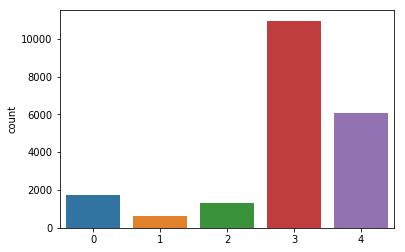

In [33]:
ageClass_te = np.concatenate([data_train[1], data_test[1]])[:,0] #target

Z_aux = np.zeros((ageClass_te.shape[0]), dtype='int')
for i in range(Z_aux.shape[0]):
    Z_aux[i] = continous_2_cat(ageClass[i]) #int(gt_aux[i]/10)
    
sns.countplot(Z_aux)
plt.show()

In [92]:
aux = sio.loadmat("/home/fmena/Downloads/MatlabFiles/Fam2a.mat")
aux["coll"]

array([[(array([[(array(['c:\\research\\flickr\\query_groupShots\\Q4\\FamilyPortraitRel1\\1000306439_a1744969b8_1369_11099615@N00.jpg'],
      dtype='<U101'), array(['10-Nov-2008'], dtype='<U11'), array([[733722.29371057]]), array([[261, 143, 271, 143]], dtype=uint16), array([[882.]], dtype=float32), array([[500, 375]], dtype=uint16)),
        (array(['c:\\research\\flickr\\query_groupShots\\Q4\\FamilyPortraitRel1\\1000306439_a1744969b8_1369_11099615@N00.jpg'],
      dtype='<U101'), array(['10-Nov-2008'], dtype='<U11'), array([[733722.2937113]]), array([[295, 118, 304, 117]], dtype=uint16), array([[918.]], dtype=float32), array([[500, 375]], dtype=uint16)),
        (array(['c:\\research\\flickr\\query_groupShots\\Q4\\FamilyPortraitRel1\\1000306439_a1744969b8_1369_11099615@N00.jpg'],
      dtype='<U101'), array(['10-Nov-2008'], dtype='<U11'), array([[733722.2937113]]), array([[216, 160, 225, 160]], dtype=uint16), array([[894.]], dtype=float32), array([[500, 375]], dtype=uint16)),
      

In [100]:
aux["coll"][0][0][1]

array([[16],
       [16],
       [16],
       ...,
       [28],
       [28],
       [ 1]], dtype=uint8)

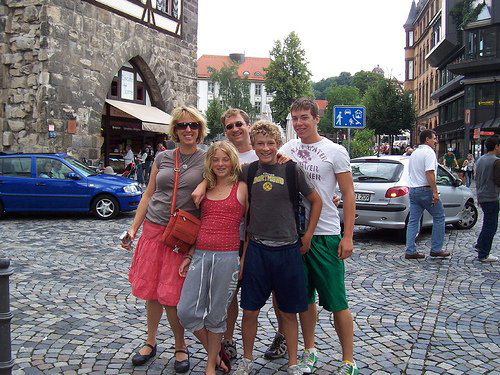

In [93]:
Image.open("/home/fmena/Downloads/Fam2a/1000306439_a1744969b8_1369_11099615@N00.jpg")

In [43]:
imgs = aux["coll"][0][0][7][0] #fimg

for i in range(imgs.shape[0]):
    print(imgs[i][0].shape)
#imgs[0][0].shape

(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(61, 49)
(

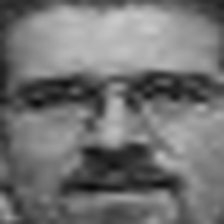

In [146]:

aux = Image.fromarray(imgs[0][0], 'L').convert("RGB")
aux.resize((224,224), Image.ANTIALIAS)

In [59]:
np.random.seed(0)
mask_test = np.random.rand(Z_data.shape[0]) < 0.25

Z_train = Z_data[~mask_test]
r_obs = r_obs_aux[~mask_test]

#Xstd_train = new_X[~mask_test]
Xstd_train = np.concatenate([new_X[~mask_test],new_X3[~mask_test]],axis=0)
Z_train = np.tile(Z_train, 2)
#if r_obs.shape[0] != Z_train.shape[0]:
r_obs = np.tile(r_obs, (2,1))

Z_test = Z_data[mask_test]
Xstd_test = new_X[mask_test]

print("Input train shape:",Xstd_train.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",Xstd_test.shape)
print("Label test shape:",Z_test.shape)



N, K = r_obs.shape

print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

Input train shape: (1494, 7, 7, 512)
Label train shape: (1494,)
Input test shape: (255, 7, 7, 512)
Label test shape: (255,)
repeats shape:  (1494, 7)
Classes:  7


In [24]:
Z_train = Z_data.copy()
Z_test = Z_data_te.copy()

Xstd_train = new_X.copy()
Xstd_test = new_X_te.copy()

print("Input train shape:",Xstd_train.shape)
print("Label train shape:",Z_train.shape)

print("Input test shape:",Xstd_test.shape)
print("Label test shape:",Z_test.shape)


N, K = r_obs.shape
print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

NameError: name 'Z_data_te' is not defined

#### Delta Convergence criteria

In [60]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN,CNN_simple, RNN_simple, Clonable_Model

from code.utils import EarlyStopRelative
from code.utils import *
from code.representation import *
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

In [61]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
mv_conf_soft = generate_confusionM(mv_soft, r_obs) #confusion matrix of all annotators

mv_onehot = keras.utils.to_categorical(mv_soft.argmax(axis=-1))
mv_conf_onehot = generate_confusionM(mv_onehot, r_obs) #confusion matrix of all annotators

print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=-1)==Z_train))

ACC MV on train: 0.6238286479250335


In [62]:
Z_train_onehot = keras.utils.to_categorical(Z_train, num_classes=K)
Z_test_onehot = keras.utils.to_categorical(Z_test, num_classes=K)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 7, 7, 512)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 7, 7, 64)          294976    
_________________________________________________________________
batch_normalization_34 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 576)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               73856     
__________

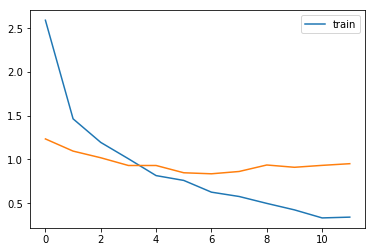

In [57]:
from keras.models import Sequential

model_UB = CNN_simple(Xstd_train.shape[1:],r_obs.shape[1], 64, 1, BN=True,drop=0.5,double=False,
                      global_pool=False,dense_units=128) #glob False
#model_UB = Sequential()
#model_UB.add(Conv2D(128, (3,3), activation='relu', input_shape=Xstd_train.shape[1:], padding='valid'))
#model_UB.add(BatchNormalization())
#model_UB.add(MaxPool2D(2,2))
#model_UB.add(Conv2D(128, (3,3), activation='relu', padding='same'))
#model_UB.add(BatchNormalization())
#model_UB.add(MaxPool2D(2,2))

#model_UB.add(Flatten())    
#model_UB.add(GlobalAveragePooling2D())

#model_UB.add(Dense(r_obs.shape[1], activation='softmax'))

#model_UB = CNN_simple(Xstd_train.shape[1:],r_obs.shape[1],1, 1, BN=True,drop=0.0,double=False,
#                      global_pool=False,dense_units=64)

model_UB.summary()
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist=model_UB.fit(Xstd_train, Z_train_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,
                  callbacks=[ourCallback],
                 validation_data=(Xstd_test,Z_test_onehot))
#K.set_image_data_format('channels_first')
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 25088)             0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 25088)             100352    
_________________________________________________________________
dense_55 (Dense)             (None, 128)               3211392   
_________________________________________________________________
batch_normalization_43 (Batc (None, 128)               512       
_________________________________________________________________
dropout_46 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 128)               16512     
__________

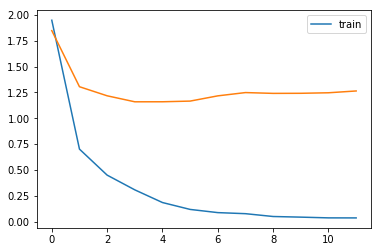

In [64]:
model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,2,BN=True,drop=0.5) #128 con 0.5 o 0.25
#model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],64,2,BN=True,drop=0.25)

model_UB.summary()
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist=model_UB.fit(Xstd_train, Z_train_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=1,
                  callbacks=[ourCallback],
                 validation_data=(Xstd_test,Z_test_onehot))
clone_UB = Clonable_Model(model_UB)
plt.plot(hist.history["loss"],label="train")
plt.plot(hist.history["val_loss"])
plt.legend()

In [47]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT,metrics=["acc"])
hist=model_mvsoft.fit(Xstd_train, mv_soft, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(Xstd_train)
Z_test_pred = model_mvsoft.predict_classes(Xstd_test)

Trained model over soft-MV, Epochs to converge = 7


In [49]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(Xstd_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(Xstd_train)
Z_test_pred = model_mvhard.predict_classes(Xstd_test)

Trained model over hard-MV, Epochs to converge = 19


### Our Proposed

In [22]:
from code.MixtureofGroups import GroupMixtureGlo

aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

Normalized entropy (0-1) of repeats annotations: 0.37181571824927173


In [ ]:
gMixture_Global = GroupMixtureOpt(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=4,epochs=0,pre_init=0,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("simple cnn",32,3,BatchN=False,drop=0.25,double=True,h_units=512)
gMixture_Global.lambda_random = True 
logL_hists,i_r = gMixture_Global.multiples_run(1,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL
                               ,cluster=True)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [35]:
M_seted = 3 #??

""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups
uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [34]:
TOL

0.03

In [44]:
gMixture_Global = GroupMixtureGlo(Xstd_train.shape[1:],Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("simple cnn",128, 1, BatchN=True,drop=0.25,double=False,h_units=0,glo_p=True )
#gMixture_Global.define_model("mlp",128,1,BatchN=True,drop=0.0)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                               tolerance=0.05,
                                              pre_init_z=0)

Needed params (units,deep,drop,double?,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.003752 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (747, 7)
Betas:  (3, 7, 7)
Q estimate:  (747, 7, 3, 7)
Iter 1/50
M step: done,  E step: done //  (in 1.99 sec)	logL: -8614.011	
Iter 2/50
M step: done,  E step: done //  (in 0.42 sec)	logL: -7824.601	Tol1: 0.09164	Tol2: 0.48273	Tol3: 0.05656	
Iter 3/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -7577.915	Tol1: 0.03153	Tol2: 0.23125	Tol3: 0.02521	
Iter 4/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -7303.767	Tol1: 0.03618	Tol2: 0.12298	Tol3: 0.01078	
Iter 5/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -7112.273	Tol1: 0.02622	Tol2: 0.10863	Tol3: 0.04204	
Iter 6/50
M step: done,  E step: done //  (in 0.44 sec)	logL: -7006.268	Tol1: 0.01490	Tol2: 0.12011	Tol3: 0.04418	
Iter 7/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -7013.480	Tol1: 0.00103	Tol2: 0.09394	Tol3: 0.03355	


M step: done,  E step: done //  (in 1.57 sec)	logL: -8741.400	
Iter 2/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7649.801	Tol1: 0.12488	Tol2: 0.50081	Tol3: 0.06659	
Iter 3/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -7287.877	Tol1: 0.04731	Tol2: 0.24900	Tol3: 0.03311	
Iter 4/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7133.551	Tol1: 0.02118	Tol2: 0.12031	Tol3: 0.00859	
Iter 5/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -7045.165	Tol1: 0.01239	Tol2: 0.08142	Tol3: 0.02339	
Iter 6/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6973.122	Tol1: 0.01023	Tol2: 0.09533	Tol3: 0.01529	
Iter 7/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6931.666	Tol1: 0.00595	Tol2: 0.07603	Tol3: 0.02103	
Iter 8/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6873.743	Tol1: 0.00836	Tol2: 0.07632	Tol3: 0.01718	
Iter 9/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6826.994	Tol1: 0.00680	Tol2: 0.06008	Tol3: 0.02681	
Iter 10/50
M step

M step: done,  E step: done //  (in 0.36 sec)	logL: -6932.999	Tol1: 0.01678	Tol2: 0.09972	Tol3: 0.03609	
Iter 7/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6952.779	Tol1: 0.00285	Tol2: 0.07453	Tol3: 0.02386	
Iter 8/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6927.390	Tol1: 0.00365	Tol2: 0.09614	Tol3: 0.02037	
Iter 9/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7021.436	Tol1: 0.01358	Tol2: 0.09369	Tol3: 0.01951	
Iter 10/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -6981.228	Tol1: 0.00573	Tol2: 0.09194	Tol3: 0.01373	
Iter 11/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7003.319	Tol1: 0.00316	Tol2: 0.08378	Tol3: 0.01118	
Iter 12/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6947.003	Tol1: 0.00804	Tol2: 0.09469	Tol3: 0.00974	
Iter 13/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6863.567	Tol1: 0.01201	Tol2: 0.06735	Tol3: 0.01179	
Iter 14/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6670.457	Tol1: 0.02814

M step: done,  E step: done //  (in 0.37 sec)	logL: -6460.432	Tol1: 0.00760	Tol2: 0.09789	Tol3: 0.05501	
Iter 31/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6519.457	Tol1: 0.00914	Tol2: 0.08611	Tol3: 0.04596	
Iter 32/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6417.843	Tol1: 0.01559	Tol2: 0.08934	Tol3: 0.03774	
Iter 33/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6390.047	Tol1: 0.00433	Tol2: 0.09266	Tol3: 0.05030	
Iter 34/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6355.898	Tol1: 0.00534	Tol2: 0.06184	Tol3: 0.05040	
Iter 35/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6371.731	Tol1: 0.00249	Tol2: 0.05965	Tol3: 0.05729	
Iter 36/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6330.389	Tol1: 0.00649	Tol2: 0.06294	Tol3: 0.05530	
Iter 37/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6298.669	Tol1: 0.00501	Tol2: 0.08184	Tol3: 0.06279	
Iter 38/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6242.790	Tol1: 0.00

M step: done,  E step: done //  (in 0.36 sec)	logL: -6806.567	Tol1: 0.00087	Tol2: 0.06798	Tol3: 0.01395	
Iter 20/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6863.654	Tol1: 0.00839	Tol2: 0.07398	Tol3: 0.02537	
Iter 21/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -6723.061	Tol1: 0.02048	Tol2: 0.09642	Tol3: 0.00687	
Iter 22/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6677.165	Tol1: 0.00683	Tol2: 0.09133	Tol3: 0.04601	
Iter 23/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6706.498	Tol1: 0.00439	Tol2: 0.11524	Tol3: 0.03853	
Iter 24/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6675.550	Tol1: 0.00461	Tol2: 0.14587	Tol3: 0.03556	
Iter 25/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6758.770	Tol1: 0.01247	Tol2: 0.09429	Tol3: 0.02700	
Iter 26/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6601.226	Tol1: 0.02331	Tol2: 0.11115	Tol3: 0.02744	
Iter 27/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6548.545	Tol1: 0.00

M step: done,  E step: done //  (in 0.36 sec)	logL: -6331.929	Tol1: 0.00289	Tol2: 0.08041	Tol3: 0.04191	
Iter 29/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6343.725	Tol1: 0.00186	Tol2: 0.06258	Tol3: 0.04282	
Iter 30/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6266.988	Tol1: 0.01210	Tol2: 0.06264	Tol3: 0.04213	
Iter 31/50
M step: done,  E step: done //  (in 0.38 sec)	logL: -6301.403	Tol1: 0.00549	Tol2: 0.08792	Tol3: 0.06076	
Iter 32/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6192.543	Tol1: 0.01728	Tol2: 0.09612	Tol3: 0.05937	
Iter 33/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6171.200	Tol1: 0.00345	Tol2: 0.07272	Tol3: 0.06572	
Iter 34/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6141.464	Tol1: 0.00482	Tol2: 0.05999	Tol3: 0.07113	
Iter 35/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6147.402	Tol1: 0.00097	Tol2: 0.06902	Tol3: 0.07794	
Iter 36/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -6112.333	Tol1: 0.00

M step: done,  E step: done //  (in 0.36 sec)	logL: -7015.409	Tol1: 0.01022	Tol2: 0.09547	Tol3: 0.03893	
Iter 9/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7138.321	Tol1: 0.01752	Tol2: 0.07434	Tol3: 0.03870	
Iter 10/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7021.616	Tol1: 0.01635	Tol2: 0.12202	Tol3: 0.01848	
Iter 11/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -7041.557	Tol1: 0.00284	Tol2: 0.05260	Tol3: 0.01677	
Iter 12/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6968.303	Tol1: 0.01040	Tol2: 0.07009	Tol3: 0.01290	
Iter 13/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6928.061	Tol1: 0.00578	Tol2: 0.05937	Tol3: 0.02550	
Iter 14/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6961.778	Tol1: 0.00487	Tol2: 0.07690	Tol3: 0.01820	
Iter 15/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6853.561	Tol1: 0.01554	Tol2: 0.07029	Tol3: 0.01212	
Iter 16/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6812.253	Tol1: 0.006

M step: done,  E step: done //  (in 0.36 sec)	logL: -6409.866	Tol1: 0.00526	Tol2: 0.06091	Tol3: 0.04673	
Iter 28/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6308.960	Tol1: 0.01574	Tol2: 0.10784	Tol3: 0.04383	
Iter 29/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6378.409	Tol1: 0.01101	Tol2: 0.05724	Tol3: 0.05711	
Iter 30/50
M step: done,  E step: done //  (in 0.35 sec)	logL: -6354.087	Tol1: 0.00381	Tol2: 0.10993	Tol3: 0.05784	
Iter 31/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6342.725	Tol1: 0.00179	Tol2: 0.07523	Tol3: 0.05443	
Iter 32/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6299.300	Tol1: 0.00685	Tol2: 0.07177	Tol3: 0.06646	
Iter 33/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6292.512	Tol1: 0.00108	Tol2: 0.06086	Tol3: 0.06958	
Iter 34/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6282.847	Tol1: 0.00154	Tol2: 0.05786	Tol3: 0.07667	
Iter 35/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6221.925	Tol1: 0.00

Alphas:  (3,)
MV init:  (747, 7)
Betas:  (3, 7, 7)
Q estimate:  (747, 7, 3, 7)
Iter 1/50
M step: done,  E step: done //  (in 1.56 sec)	logL: -8783.979	
Iter 2/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7779.333	Tol1: 0.11437	Tol2: 0.48940	Tol3: 0.06751	
Iter 3/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7582.300	Tol1: 0.02533	Tol2: 0.24612	Tol3: 0.02580	
Iter 4/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7335.133	Tol1: 0.03260	Tol2: 0.13357	Tol3: 0.02197	
Iter 5/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7168.139	Tol1: 0.02277	Tol2: 0.09680	Tol3: 0.01492	
Iter 6/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -7120.285	Tol1: 0.00668	Tol2: 0.06051	Tol3: 0.01416	
Iter 7/50
M step: done,  E step: done //  (in 0.36 sec)	logL: -6938.931	Tol1: 0.02547	Tol2: 0.13037	Tol3: 0.03720	
Iter 8/50
M step: done,  E step: done //  (in 0.37 sec)	logL: -6870.320	Tol1: 0.00989	Tol2: 0.07398	Tol3: 0.02758	
Iter 9/50
M step: done,  E step: done //  (

In [45]:
Z_train_p = gMixture_Global.base_model.predict(Xstd_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.base_model.predict(Xstd_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
y_o_groups = gMixture_Global.get_predictions_groups(Xstd_test,data=Z_test_p).argmax(axis=-1)

### Compare trained models

In [42]:
#Import it:
from code.evaluation import Evaluation_metrics

In [63]:
#model_UB = MLP_Keras(Xstd_train.shape[1:],Z_train_onehot.shape[1],128,1,BN=True,drop=0.25)

model_UB = CNN_simple(Xstd_train.shape[1:],r_obs.shape[1],128,1, BN=True,drop=0.25,double=False,
                      global_pool=True,dense_units=0)

clone_UB = Clonable_Model(model_UB)

In [64]:
aux_tr = []
aux_te = []
eps = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(Xstd_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    Z_train_pred = model_UB.predict_classes(Xstd_train)
    Z_test_pred = model_UB.predict_classes(Xstd_test)

    evaluate = Evaluation_metrics(model_UB,'keras',Xstd_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    eps.append(len(hist.epoch))
    
print("Epochs: ",np.mean(eps))
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("LabelMe_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("LabelMe_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("LabelMe_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("LabelMe_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

Epochs:  20.55


,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,1,1,1,0,0,0


In [21]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.647255,0.647255,0.60389,0.013946,0.013946,0.024589


* VGG Face
    * standarize
        * bn y dropa 0.5  : 68
        * bn y dropa 0.25 : 67
        * bn y dropa: 0.0 : 67
     * normal
        * bn y dropa 0.5  : 68.7
        * bn y dropa 0.25 : 69.4
        * bn y dropa 0.0  : 69
        * bn(256) y drop 0.25: 
     * Entrenando (None):
        * bn(128) dropa 0: 69.6, con drop 0.25: 69.8
     
* ResNet
    * standarize
        * bn y dropa 0.5  : 68-9
        * bn y dropa 0.25 : 68
        * bn y dropa: 0.0 : 68
     * normal
        * bn y dropa 0.5  : 68-9
        * bn y dropa 0.25 : 68
        * bn y dropa 0.0  : 68

*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on global version


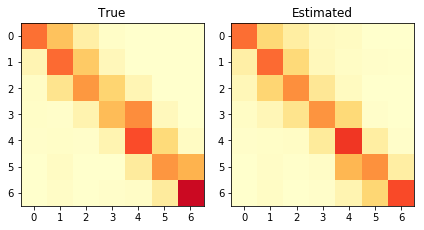

JS divergence: 0.042	Norm Frobenius: 0.080
A result


,,Accuracy,F1 (micro),F1 (macro),(G) NormF,(G) JS
0,All,0.5957,0.5957,0.5985,0.0803,0.0418


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5373,0.5373,0.538


In [48]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',Xstd_train.shape[0])
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,
                                      conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_soft)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on global version


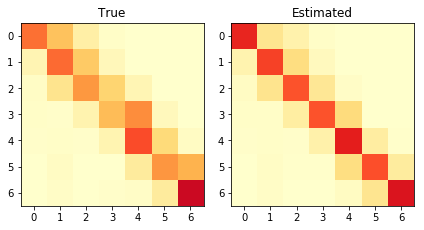

JS divergence: 0.033	Norm Frobenius: 0.087
A result


,,Accuracy,F1 (micro),F1 (macro),(G) NormF,(G) JS
0,All,0.6238,0.6238,0.6103,0.0867,0.0328


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5804,0.5804,0.5847


In [50]:
evaluate = Evaluation_metrics(model_mvhard,'keras',Xstd_train.shape[0])
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,
                                      conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on global version


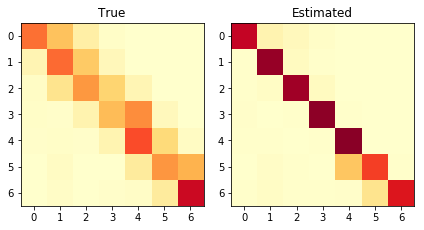

JS divergence: 0.179	Norm Frobenius: 0.186
A result


,,Accuracy,F1 (micro),F1 (macro),(G) NormF,(G) JS
0,All,0.585,0.585,0.574,0.1864,0.1792


Test


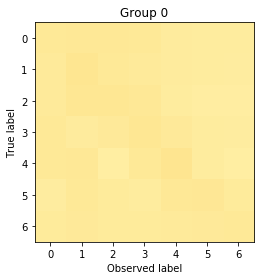

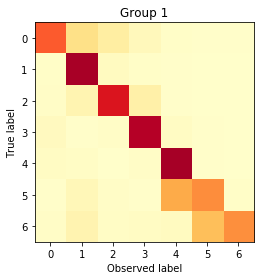

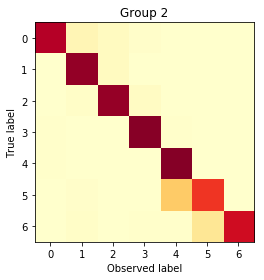

Inertia JS: 0.3105183711432442
Inertia NormF: 0.2137551554933594
A result


,Groups,Prob,Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.0011,1.9420,0.1609,0.3369,0.0211,0.0094,1,0.3105,0.2138,0.4588,0.4588
1,1,0.1270,0.8208,0.7266,0.8378,0.6810,0.0591,4,0.3105,0.2138,0.5843,0.5843
2,2,0.8719,0.3508,0.8954,0.9432,0.8779,0.0388,4,0.3105,0.2138,0.5686,0.5686


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.5569,0.5569,0.5604


In [46]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
#aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
#predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
#evaluate.labels_plot = labels
print("*** Ours Global multiples runs***")

print("Train")
prob_Yz = gMixture_Global.calculate_Yz()
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred, 
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

print("Test")
c_M = gMixture_Global.get_confusionM()
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups= y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1') 
#aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False,p_z=Z_train_p)
#predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
#evaluate.labels_plot = labels
print("*** Ours Global multiples runs (uniform) ***")

print("Train")
prob_Yz = gMixture_Global.calculate_Yz()
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred, 
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

print("Test")
c_M = gMixture_Global.get_confusionM()
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups= y_o_groups)